# Zaliczenie

Pobierz dane z ankiety StackOverflow z roku 2018 

https://drive.google.com/uc?export=download&id=1_9On2-nsBQIw3JiY43sWbrF8EjrqrR4U

Zapisz je na systemie rozproszonym (HDFS) i w swojej bazie stwórz z nich tabelę.

1. Ile przestrzeni zajmuje plik na HDFS? Ile ma partycji?
2. Jakie są wymiary stworzonej tabeli? 
3. Wyznacz średni wiek w top 10 krajach pod wzgledem liczby respondentów i zaprezentuj wyniki w postaci wykresu słupkowego
4. Wyznacz średnią wartość wynagrodzenia per kraj w roku 2018 i 2019. Zaprezentuj roznice na wykresie slupkowym dla 5 krajów o najwyższych srednich w 2019.




In [11]:
import os 
user_name = os.environ.get('USER')

import random
port_name = random.randint(4000, 4999)
port_name

from pyspark.sql import SparkSession

spark = SparkSession \
.builder \
.master('yarn-client') \
.config('spark.driver.memory', '1g') \
.config('spark.executor.memory', '1g') \
.config('spark.ui.port', port_name) \
.appName(f'zliczenie_{user_name}') \
.getOrCreate()


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
# https://drive.google.com/open?id=1QOmVDpd8hcVYqqUXDXf68UMDWQZP0wQV
gdd.download_file_from_google_drive(file_id="1_9On2-nsBQIw3JiY43sWbrF8EjrqrR4U", 
                                   dest_path="./survey208.zip",
                                   unzip=True)

Unzipping...Done.


In [4]:
!hdfs dfs -mkdir -p hdfs:///user/${USER}/survey2018/data

In [6]:
!ls

brca.txt			      so_survey_2019.pdf
data				      spark ML.ipynb
Developer_Survey_Instrument_2018.pdf  StackOverflowSurvey.ipynb
ds_lab.ipynb			      survey208.zip
__MACOSX			      survey_results_public.csv
my_env				      survey_results_schema.csv
README_2018.txt			      survey.zip
README_2019.txt			      zal.ipynb


In [7]:
!hdfs dfs -put -f survey_results_public.csv hdfs:///user/${USER}/survey2018/data

In [8]:
!hdfs dfs -ls hdfs:///user/${USER}/survey2018/data

Found 1 items
-rw-r--r--   2 lksiezak bdg-ds-stud  195595827 2020-01-26 10:25 hdfs:///user/lksiezak/survey2018/data/survey_results_public.csv


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
path = f"/user/{user_name}/survey2018/data/survey_results_public.csv"
table_name = "survey2018"

In [14]:
spark.sql(f"USE {user_name}")

DataFrame[]

In [15]:
spark.sql(f"CREATE TABLE IF NOT EXISTS {table_name} \
            using CSV \
            OPTIONS (HEADER=TRUE, INFERSCHEMA TRUE, NULLVALUE 'NA') \
            LOCATION '{path}'")

DataFrame[]

# 1. Ile przestrzeni zajmuje plik na HDFS? Ile ma partycji?

Total size:	195595827 B
Przechowywany w dwóch kopiach (186.5 M  373.1 M  )
W dwoch partycjach (Total blocks (validated):	2 )

In [18]:
!hdfs fsck hdfs:///user/lksiezak/survey2018/data/survey_results_public.csv

Connecting to namenode via http://cdh01.cl.ii.pw.edu.pl:50070/fsck?ugi=lksiezak&path=%2Fuser%2Flksiezak%2Fsurvey2018%2Fdata%2Fsurvey_results_public.csv
FSCK started by lksiezak (auth:KERBEROS_SSL) from /192.168.157.200 for path /user/lksiezak/survey2018/data/survey_results_public.csv at Sun Jan 26 10:33:06 CET 2020

Status: HEALTHY
 Number of data-nodes:	4
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	195595827 B
 Total files:	1
 Total blocks (validated):	2 (avg. block size 97797913 B)
 Minimally replicated blocks:	2 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	2
 Average block replication:	2.0
 Missing blocks:		0
 Corrupt blocks:		0
 Missing replicas:		0 (0.0 %)

Erasure Coded Block Groups:
 Total size:	0 B
 Total files:	0
 Total block groups (validated):	0
 Minimally erasure-coded block groups:	0
 Over-erasure-coded block groups:	0
 Under-er

In [17]:
!hdfs dfs -du -h hdfs:///user/lksiezak/survey2018/data/survey_results_public.csv

186.5 M  373.1 M  hdfs:///user/lksiezak/survey2018/data/survey_results_public.csv


# 2. Jakie sa wymiary tabeli

129 x 98855

In [41]:
pandas_df =spark.sql(f"DESCRIBE {table_name}").toPandas() # show(200, truncate=False)
pandas_df.shape[0]

129

In [31]:
spark.sql(f"SELECT COUNT(*) FROM {table_name}").show()

+--------+
|count(1)|
+--------+
|98855   |
+--------+



# 3. Wyznacz średna pensje w top 10 krajach pod wzgledem liczby respondentów i zaprezentuj wyniki w postaci wykresu słupkowego

In [80]:
avgSal = spark.sql(f"SELECT Country, MEAN(ConvertedSalary) AS avgSal, COUNT(*) AS noOfRespondents\
            FROM {table_name}\
            GROUP BY Country\
            HAVING COUNT(*)\
            ORDER BY noOfRespondents DESC\
            LIMIT 10").toPandas()
avgSal

,Country,avgSal,noOfRespondents
0,United States,154413.1285,20309
1,India,27694.1215,13721
2,Germany,91850.6112,6459
3,United Kingdom,128216.9309,6221
4,Canada,100894.3434,3393
5,Russian Federation,26312.2299,2869
6,France,89410.8998,2572
7,Brazil,57796.9635,2505
8,Poland,38472.7476,2122
9,Australia,126623.7203,2018


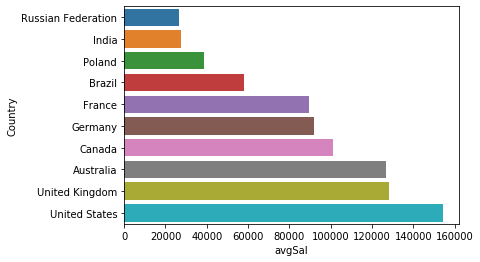

In [82]:
sns.barplot(y="Country", x="avgSal", data=avgSal.sort_values("avgSal"))

# Wyznacz średnią wartość wynagrodzenia per kraj w roku 2018 i 2019. Zaprezentuj roznice na wykresie slupkowym dla 5 krajów o najwyższych srednich w 2019

In [97]:
table_name = "survey2018"
avg_per_country_2018 = spark.sql(f"SELECT Country, MEAN(ConvertedSalary) AS avgSal\
                                    FROM {table_name}\
                                    WHERE Country IS NOT NULL AND ConvertedSalary IS NOT NULL \
                                    GROUP BY Country\
                                    ORDER BY avgSal DESC").toPandas()
avg_per_country_2018

,Country,avgSal
0,Andorra,525089.5000
1,Liechtenstein,284028.0000
2,"Venezuela, Bolivarian Republic of...",241823.6250
3,Ireland,186313.2167
4,Botswana,170000.0000
...,...,...
152,Eritrea,3000.0000
153,Swaziland,2476.0000
154,Zambia,1824.0000
155,Dominica,1000.0000


In [98]:
table_name = "survey"
avg_per_country_2019 = spark.sql(f"SELECT Country, MEAN(ConvertedComp) AS avgSal\
                                    FROM {table_name}\
                                    WHERE Country IS NOT NULL AND ConvertedComp IS NOT NULL \
                                    GROUP BY Country\
                                    ORDER BY avgSal DESC\
                                    LIMIT 5").toPandas()
avg_per_country_2019

,Country,avgSal
0,Liechtenstein,811188.0000
1,San Marino,301788.0000
2,Ireland,250342.2391
3,United States,249546.2546
4,Swaziland,242607.5000


In [121]:
avg_per_country_2018
avg_per_country_2019

result = pd.merge(avg_per_country_2019,avg_per_country_2018,
                 on='Country', 
                 how='inner')

result 
#result.avgSal_x-result.avgSal_y

,Country,avgSal_x,avgSal_y
0,Liechtenstein,811188.0000,284028.0000
1,Ireland,250342.2391,186313.2167
2,United States,249546.2546,154413.1285
3,Swaziland,242607.5000,2476.0000


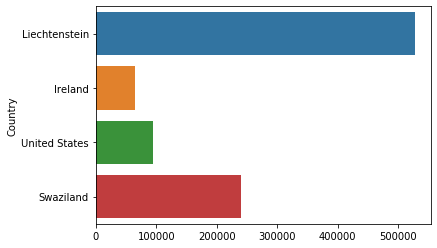

In [122]:
sns.barplot(y="Country", x=result.avgSal_x-result.avgSal_y, data=result)
